## CLIP Interrogation

Этот ноутбук позволит вам сгенерировать промпт по изображению - провести своего рода реверс-инжиниринг промпта.

Для начала, установим необходимые библиотеки:

In [1]:
%pip install -q clip-interrogator 


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Если в предыдущем примере что-то пошло не так - уберите ключик `-q`, чтобы посмотреть полный отчёт по установке.

Далее избавимся от лишних предупреждений:

In [2]:
import warnings
warnings.filterwarnings("ignore")

Опишем главные функции для извлечение промптов из изображений. Что тут можно поменять:
* Использовать другие модели распознавания из заданного списка
* Изменить флаг `quiet`, чтобы наблюдать за процессом

Эти изменения можно делать и ниже по ходу процесса.

In [3]:
from clip_interrogator import Config, Interrogator

caption_models = ["blip-base", "blip-large", "git-large-coco","blip2-2.7b","blip2-flan-t5-xl"]
# use blip2 family models with caution on large GPUs

clip_models = ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

config = None
ci = None

def set_models(clip_model_name=None,caption_model_name=None,quiet=None):
    global config, ci
    config = Config()
    if clip_model_name:
        config.clip_model_name = clip_model_name
    if caption_model_name:
        config.caption_model_name = caption_model_name
    if quiet is not None:
        config.quiet = quiet
    ci = Interrogator(config)
    print(f"Setting clip_model={clip_model_name}, caption_model={caption_model_name}")

set_models(clip_models[0],caption_models[1],quiet=True)
    
def image_analysis(image,top=5):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, top)
    top_artists = ci.artists.rank(image_features, top)
    top_movements = ci.movements.rank(image_features, top)
    top_trendings = ci.trendings.rank(image_features, top)
    top_flavors = ci.flavors.rank(image_features, top)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}
    
    return { 'Medium' : medium_ranks, 
             'Artist' : artist_ranks, 
             'Movement' : movement_ranks,
             'Trending' : trending_ranks,
             'Flavor' : flavor_ranks }

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)
        
        
def analyze(image,top=5):
    print(f"Best prompt: {image_to_prompt(image,'best')}")
    print(f"Classic prompt: {image_to_prompt(image,'classic')}")
    print(f"Negative prompt: {image_to_prompt(image,'negative')}")
    res = image_analysis(image,top)
    for k,v in res.items():
        print(f"{k}:")
        for x,sim in v.items():
            print(f" + {x} - {sim}")

2025-03-11 09:52:36.941044: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 09:52:36.986901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 09:52:39.983924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Setting clip_model=ViT-L-14/openai, caption_model=blip-large


Возьмём одно изображение и проанализируем его

> Это может занять некоторое время

![](images/natura-morta-con-tralcio-di-fiori.jpg)

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("images/natura-morta-con-tralcio-di-fiori.jpg")
analyze(img,7)

Best prompt: painting of a bunch of flowers in a vase on a table, mat collishaw, inspired by Gabriel Metsu, brown and gold color palette
Classic prompt: painting of a bunch of flowers in a vase on a table, a flemish Baroque by Johannes Bosschaert, featured on flickr, hyperrealism, flowers. baroque elements, mat collishaw, ambrosius bosschaert the elder
Negative prompt: crochet octopus eating sushi, boku no hero academia style, she hulk
Medium:
 + a flemish Baroque - 0.2291259765625
 + an oil on canvas painting - 0.20751953125
 + a still life - 0.2132568359375
 + a photorealistic painting - 0.207275390625
 + a painting - 0.1944580078125
 + an oil painting - 0.19970703125
 + a hyperrealistic painting - 0.2001953125
Artist:
 + by Johannes Bosschaert - 0.2374267578125
 + by Ambrosius Bosschaert II - 0.2373046875
 + by Abraham Bosschaert - 0.235595703125
 + by Ambrosius Bosschaert - 0.2376708984375
 + by Rachel Ruysch - 0.236572265625
 + by Balthasar van der Ast - 0.214111328125
 + by Wille

Теперь проделаем такой же анализ для нескольких изображений из папки `images`:

Opening images/amber-kipp-75715CVEJhI-unsplash.jpg


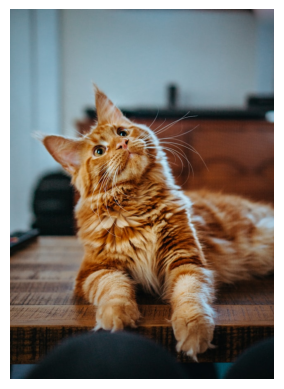

Best prompt: there is a cat that is laying down on a table, ornate golden background, featured on unsplash, very long wavy fiery red hair, reaching towards the heavens, posed in profile, looking upwards, taken with a canon eos 5d, facing sideways
Classic prompt: there is a cat that is laying down on a table, a stock photo by Hanns Katz, featured on unsplash, arabesque, ginger cat, orange cat, maine coon
Negative prompt: aron wiesenfeld dark fantasy, soldiers and mech fight, futuristic white-space-bikini, gerald brom style, 3 d graffiti texture, scifi environment, b&w, dark figures walking, japan watercolour, oil pastel gestural lines, futuristic ruins
Medium:
 + a stock photo - 0.1820068359375
 + a portrait - 0.1600341796875
 + a picture - 0.1595458984375
 + a jigsaw puzzle - 0.1614990234375
 + a still life - 0.152587890625
Artist:
 + by Hanns Katz - 0.2144775390625
 + by Alison Geissler - 0.18212890625
 + by Relja Penezic - 0.180908203125
 + by Silvia Dimitrova - 0.1866455078125
 + by

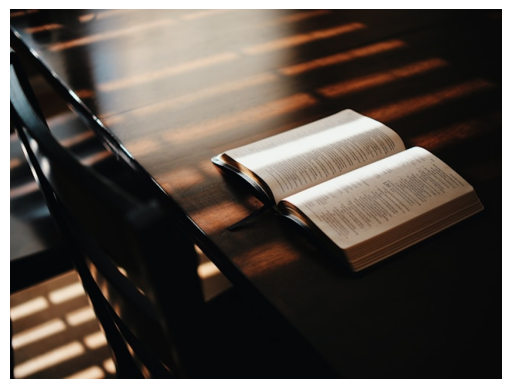

Best prompt: there is a book on a table with a chair in the background, unsplash photography, jesus christ fighting lucifer, lensflares, god's rays, shelves filled with tomes, iso 1250, otherwordly, terminal text, more details, cleric, interconnected, breastplate, character
Classic prompt: there is a book on a table with a chair in the background, a stock photo by Thota Vaikuntham, trending on unsplash, private press, an open book, christianism, ratio 16:9
Negative prompt: metart, jean dupas, anime key visual”, moebius. rich colors, so happy that her face hurts, hyper detailed illustration
Medium:
 + a stock photo - 0.1746826171875
 + a photocopy - 0.1654052734375
 + a picture - 0.14794921875
 + a flemish Baroque - 0.1507568359375
 + a storybook illustration - 0.154296875
Artist:
 + by Thota Vaikuntham - 0.173095703125
 + by Aaron Bohrod - 0.174072265625
 + by Fred A. Precht - 0.1744384765625
 + by James E. Brewton - 0.177490234375
 + inspired by Johann Balthasar Bullinger - 0.17834472

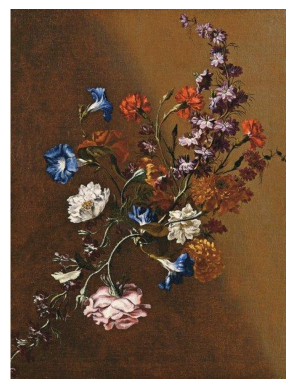

Best prompt: painting of a bunch of flowers in a vase on a table, mat collishaw, inspired by Gabriel Metsu, brown and gold color palette
Classic prompt: painting of a bunch of flowers in a vase on a table, a flemish Baroque by Johannes Bosschaert, featured on flickr, hyperrealism, flowers. baroque elements, mat collishaw, ambrosius bosschaert the elder
Negative prompt: crochet octopus eating sushi, boku no hero academia style, she hulk
Medium:
 + a flemish Baroque - 0.2291259765625
 + an oil on canvas painting - 0.20751953125
 + a still life - 0.213134765625
 + a photorealistic painting - 0.2071533203125
 + a painting - 0.1944580078125
Artist:
 + by Johannes Bosschaert - 0.2374267578125
 + by Ambrosius Bosschaert II - 0.2374267578125
 + by Abraham Bosschaert - 0.235595703125
 + by Ambrosius Bosschaert - 0.2376708984375
 + by Rachel Ruysch - 0.236572265625
Movement:
 + hyperrealism - 0.197265625
 + baroque - 0.1832275390625
 + photorealism - 0.1944580078125
 + classical realism - 0.1916

In [15]:
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for fn in glob("images/*"):
    print(f"Opening {fn}")
    img = Image.open(fn)
    show_image(img)
    analyze(img)

Попробуем с более сложными моделями (для этого потребуется расширить хранилище датасферы, т.к. модели действительно большие):

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

set_models(clip_models[1],caption_models[-1],quiet=False)

img = Image.open("images/natura-morta-con-tralcio-di-fiori.jpg")
analyze(img,7)